###### Felipe BUZATO FRANÇA COSTA | Louis GALLAIS
###### MAP512 - $École Polytechnique$

In [25]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg as linalg
sns.set_style('darkgrid')

## Wishart Processes - FX Market Numerical Experiments

The goal of this notebook is to price FX triangle options $(EUR-JPY-USD)$ considering the Wishart Stochastic Volatility model (2-dimensional). The first steps will not focus on calibration, but this will be considered later.

$ \textbf{$1^{st}$ Step:}$ $\textbf{Simulation of the Wishart Volatility Process}$

To do so, we will implement a numerical simulation that approximates the stochastic integrals to constants in small intervalls over a grid $\{t_1, t_2, ..., t_n\}$, with $n$ preferably big. This is the so called Euler-Maruyiama approximation.

$$
X_{t_{i+1}} = X_{t_i} + (\alpha a^T a + \tilde{b} \tilde{X}_{t_i} + \tilde{X}_{t_i} \tilde{b}^T) h + \tilde{X_{t_i}}^{1/2} (B_{t_{i+1}} - B_{t_i}) a + a^T (B_{t_{i+1}} - B_{t_i})^T \tilde{X_{t_i}}^{1/2},
$$

where $B_{t_i}$ is a $2x2$ brownian motion.

We will use the following values (this can be improved by calibrating the model): 

$$
a = 
\left(\begin{array}{cc} 
0.0832 & 0.0322\\
0.0322 & 0.0965
\end{array}\right)
\qquad
\tilde{b} = -
\left(\begin{array}{cc} 
0.576 & 0.235\\ 
0.235 & 0.333
\end{array}\right)
\qquad
\alpha = 1.0456
$$

In [26]:
def Wishart(a, b, alpha, T=2, n=1000, M=5):
    delta_T = T/n
    
    # Matrix that will contain the M simulations at the last time step of the 2-dimensional Wishart process
    Wisharts = np.zeros((M, n, 2, 2))

    for i in range(M):
        # We repeat M times the simulation to have M samples
        Wishart_prev = np.array([[0.1, 0.0], [0.0, 0.1]])
        Wishart_inst = np.array([[1.0, 4.0], [4.0, 1.0]])
        
        for j in range(1, n):
            
            # Drift Increment
            drift = alpha * a.T @ a + b @ Wishart_prev + Wishart_prev.T @ b.T

            # Brownian increment
            brownian = np.random.normal(0, np.sqrt(delta_T), size=(2, 2))
            brow_incr = linalg.sqrtm(Wishart_prev) @ brownian @ a
            brow_incr += a.T @ brownian.T @ linalg.sqrtm(Wishart_prev)

            # Joining the increments
            Wishart_inst = Wishart_prev + delta_T*drift + brow_incr
            
            while(not np.all(linalg.eigvals(Wishart_inst) > 0)):
                # Drift Increment
                drift = alpha * a.T @ a + b @ Wishart_prev + Wishart_prev.T @ b.T

                # Brownian increment
                brownian = np.random.normal(0, np.sqrt(delta_T), size=(2, 2))
                brow_incr = linalg.sqrtm(Wishart_prev) @ brownian @ a
                brow_incr += a.T @ brownian.T @ linalg.sqrtm(Wishart_prev)

                # Joining the increments
                Wishart_inst = Wishart_prev + delta_T*drift + brow_incr
                
            Wisharts[i][j][0][0], Wisharts[i][j][0][1] = Wishart_inst[0][0], Wishart_inst[0][1]
            Wisharts[i][j][1][0], Wisharts[i][j][1][1] = Wishart_inst[1][0], Wishart_inst[1][1]
            Wishart_prev = Wishart_inst
            
            # We can't have negative values 
            #if Wishart_inst[0][0] <= 0:
            #    Wishart_inst[0][0] = 10**(-5)
            #if Wishart_inst[0][1] <= 0:
            #    Wishart_inst[0][1] = 10**(-5)
            #if Wishart_inst[1][0] <= 0:
            #    Wishart_inst[1][0] = 10**(-5)
            #if Wishart_inst[1][1] <= 0:
            #    Wishart_inst[1][1] = 10**(-5)
        
    return Wisharts

In [27]:
# Initial values
a = np.array([[0.0832, 0.0322], [0.0322, 0.0965]])
b = -np.array([[0.576, 0.235], [0.235, 0.333]])
alpha = 1.0456

# Sampling
Wishart_ = Wishart(a, b, alpha)

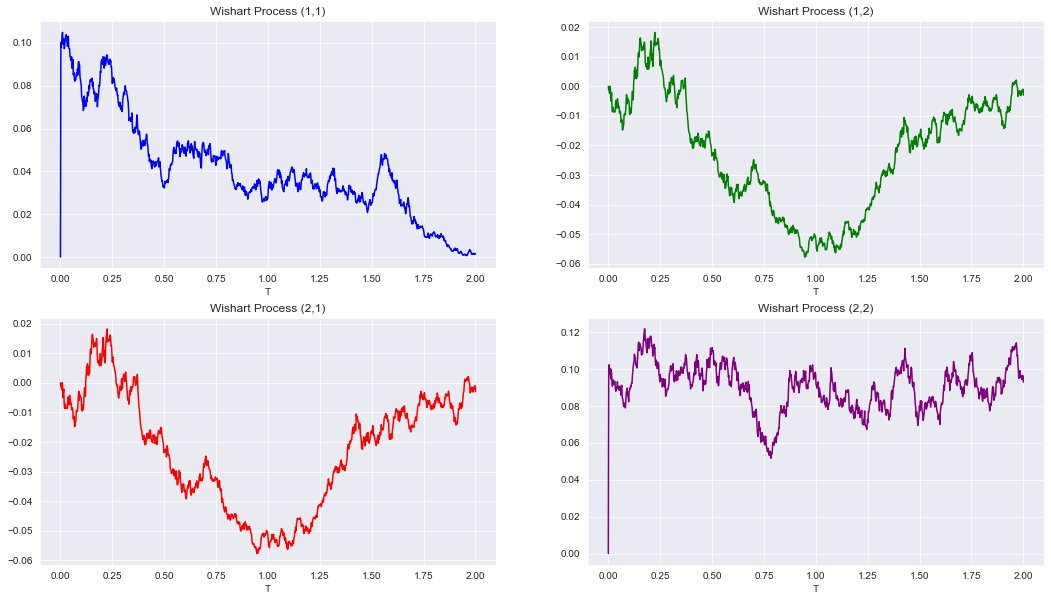

In [28]:
# Plotting one of the samples
time = np.linspace(0, 2, 1000)
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax[0,0].plot(time, Wishart_[0, :, 0, 0], color = 'blue')
ax[0,1].plot(time, Wishart_[0, :, 0, 1], color = 'green')
ax[1,0].plot(time, Wishart_[0, :, 1, 0], color = 'red')
ax[1,1].plot(time, Wishart_[0, :, 1, 1], color = 'purple')
ax[0,0].set_title("Wishart Process (1,1)")
ax[0,0].set_xlabel("T")
ax[0,1].set_title("Wishart Process (1,2)")
ax[0,1].set_xlabel("T")
ax[1,0].set_title("Wishart Process (2,1)")
ax[1,0].set_xlabel("T")
ax[1,1].set_title("Wishart Process (2,2)")
ax[1,1].set_xlabel("T")
plt.show()

$ \textbf{$2^{nd}$ Step:}$ $\textbf{Simulation of the Asset Prices}$

We will assume that the prices follow:

$$
S_t^i = S_0^i e^{(r-r_{currency}^i)t + Y_t^i}
$$
where the process $T_t^i$ is simulated with the help of the following (again) Euler approximation:

$$
Y_{t_{i+1}} = Y_{t_i} - \frac{1}{2} diag \Bigg( a^T \frac{X_{t_i} + X_{t_{i+1}}}{2} a \Bigg) \Delta t + Chol \Bigg( a^T \frac{X_{t_i} + X_{t_{i+1}}}{2} a \Bigg)  \big( B_{t_{i+1}} - B_{t_i} \big),
$$

where $B_{t_i}$ is a 2-dimensional brownian motion sampled independent of the Wishard process. 

In [29]:
def asset_price(r, r_currency1, r_currency2, a, b, alpha, T=2, n=1000, M=5):
    Wishart_ = Wishart(a, b, alpha, M=M)
    delta_T = T/n
    
    # Matrix that will contain the evolution of asset prices
    asset_price = np.zeros((M, n, 2))
    
    for i in range(M):
        for j in range(n-1):
            # Drift increment
            drift = (-1/2) * np.diag(a.T @ ((1/2)*(Wishart_[i, j]+Wishart_[i, j+1])) @ a) * delta_T
            
            # Brownian increment
            brownian_incr = linalg.cholesky(a.T @ ((1/2)*(Wishart_[i, j]+Wishart_[i, j+1])) @ a, lower=True) @ np.random.normal(0, np.sqrt(delta_T), size=(2))
            
            # Joining the increments
            asset_price[i, j+1] = asset_price[i, j] + drift + brownian_incr
    
    # So far we have the Y_tis, but we want the S_tis
    for i in range(n):
        asset_price[:, i, 0] = np.exp((r-r_currency1)*delta_T*i + asset_price[:, i, 0])
        asset_price[:, i, 1] = np.exp((r-r_currency2)*delta_T*i + asset_price[:, i, 1])
            
    return asset_price

In [30]:
# Rates in the country and in its counterpart
r = 0.1
r_currency1 = 0.11
r_currency2 = 0.13
M = 300

# Sampling the asset prices
Asset_Price = asset_price(r, r_currency1, r_currency2, a, b, alpha, M=M)

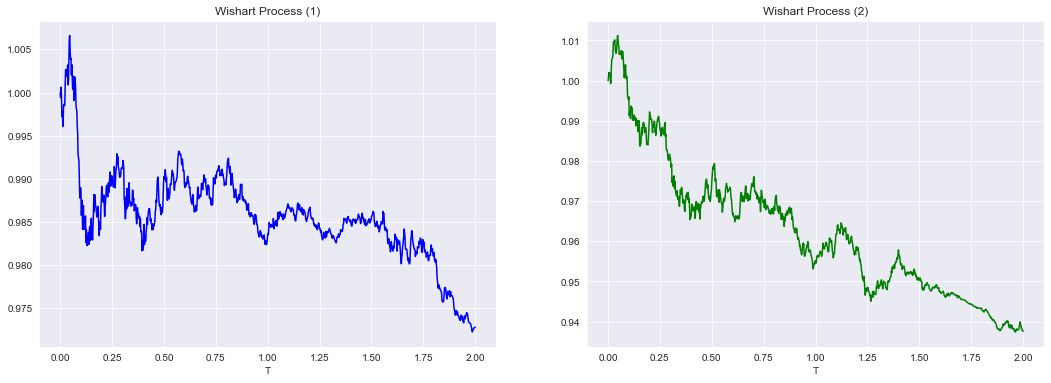

In [31]:
# Plotting one of the samples
time = np.linspace(0, 2, 1000)
fig, ax = plt.subplots(1, 2, figsize=(18,6))
ax[0].plot(time, Asset_Price[0, :, 0], color = 'blue')
ax[1].plot(time, Asset_Price[0, :, 1], color = 'green')
ax[0].set_title("Wishart Process (1)")
ax[0].set_xlabel("T")
ax[1].set_title("Wishart Process (2)")
ax[1].set_xlabel("T")
plt.show()

C:\Users\Felipe\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Felipe\anaconda3\lib\site-packages\seaborn\distributions.py:2055: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
C:\Users\Felipe\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Felipe\anaconda3\lib\site-

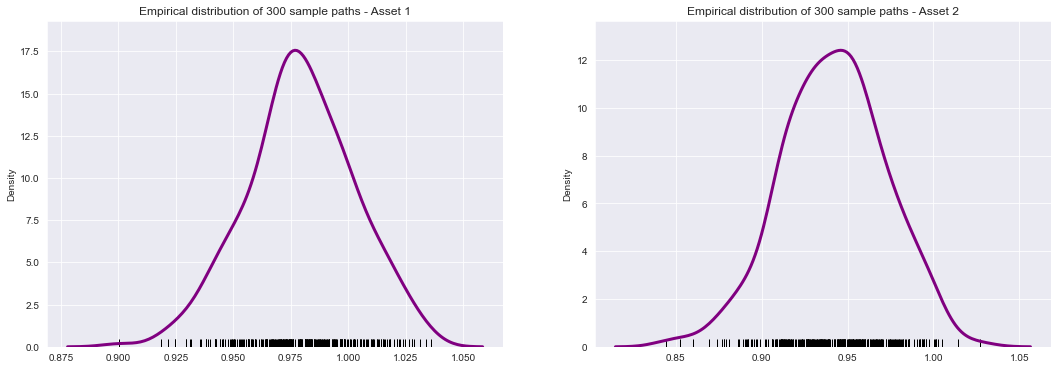

In [32]:
# Plotting the distribution of the prices
fig, ax = plt.subplots(1, 2, figsize=(18,6))
sns.distplot(Asset_Price[:, -1, 0], rug=True, hist=False, rug_kws={"color": "black"},
    kde_kws={"color": "purple", "lw": 3}, ax=ax[0])
sns.distplot(Asset_Price[:, -1, 1], rug=True, hist=False, rug_kws={"color": "black"},
    kde_kws={"color": "purple", "lw": 3}, ax=ax[1])
ax[0].set_title("Empirical distribution of %i sample paths - Asset 1"%(M))
ax[1].set_title("Empirical distribution of %i sample paths - Asset 2"%(M))
plt.show()

$ \textbf{$3^{rd}$ Step:}$ $\textbf{Evaluating the price of the options}$

To precify the option of assets 1 and 2, we will simly calculate the following expected value:

$$
C^{Asset1/EUR}(T, K) = e^{-rT} \mathbb{E}[(S_t^1 - K)_+] \qquad
C^{Asset2/EUR}(T, K) = e^{-rT} \mathbb{E}[(S_t^2 - K)_+]
$$

In [33]:
def option_pricing(Ks, asset_prices):
    
    # List that will contain the option prices for differnet strike prices Ks 
    option_prices = np.zeros((len(Ks), 2))
    
    for i in range(option_prices.shape[0]):
        payoff = lambda t: max(t-Ks[i], 0)
        
        payoffs1 = np.array([payoff(s) for s in asset_prices[:, -1, 0]])
        payoffs2 = np.array([payoff(s) for s in asset_prices[:, -1, 1]])
        
        option_prices[i, 0] = np.mean(payoffs1)
        option_prices[i, 1] = np.mean(payoffs2)
    
    return option_prices

In [34]:
Ks = [0.4 + 0.01*j for j in range(170)]
Option_Prices = option_pricing(Ks, Asset_Price)

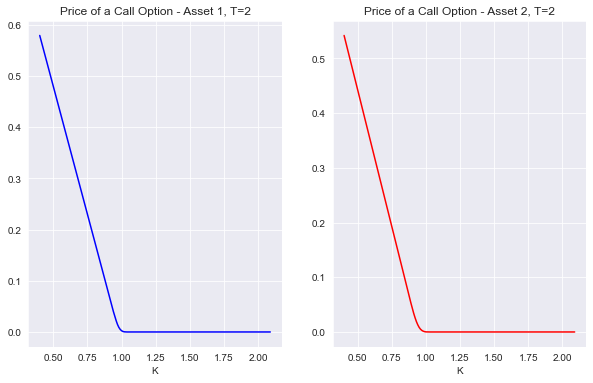

In [35]:
# Plotting the prices
fig, ax = plt.subplots(1, 2, figsize=(10,6))
ax[0].plot(Ks, Option_Prices[:, 0], color = 'blue')
ax[1].plot(Ks, Option_Prices[:, 1], color = 'red')
ax[0].set_title("Price of a Call Option - Asset 1, T=2")
ax[0].set_xlabel("K")
ax[1].set_title("Price of a Call Option - Asset 2, T=2")
ax[1].set_xlabel("K")
plt.show()